# MRI-to-sCT using pix2pix

This notebook contains code that organizes the data provided by SynthRad. Then, after the correct data folders are created and allocated, the `pix2pix` model is trained. Lastly, testing is included.

## Housekeeping and data generation

['1BB048', '1BA253', '1BB083', '1BA201', '1BA239']
There are 180 files!
Using device cuda
torch.Size([1, 228, 228])


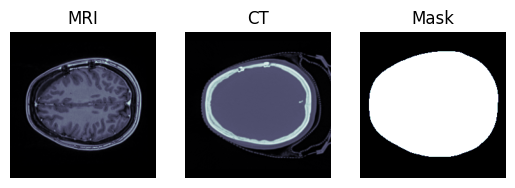

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader
import os
import nibabel as nib
import matplotlib.pyplot as plt

file_names_list = os.listdir('/content/drive/MyDrive/cs280_sp2023/project/brain/')
file_names_list.remove('.DS_Store')
file_names_list.remove('overview')
print(file_names_list[:5])
print(f"There are {len(file_names_list)} files!")

device = 'cpu'
if torch.cuda.is_available(): device = 'cuda'
print("Using device", device)

root = '/content/drive/MyDrive/cs280_sp2023/project/brain/'
num_imgs = [0]

for file in file_names_list:
    file_path = root + file + '/'

    mri = file_path + "mr.nii.gz"
    mri_img = nib.load(mri)

    num_imgs.append(num_imgs[-1] + mri_img.shape[2])

from torchvision.transforms import CenterCrop

def normalize(img):
    return cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F).astype(np.float32)

IMG_SIZE = 228
class MRI_Dataset(Dataset):

    def __init__(self, paths, slice_idx, root='/content/drive/MyDrive/cs280_sp2023/project/brain/'):
        super().__init__()
        self.files_list = paths
        self.root = root
        self.slice_idx = slice_idx
        self.center2num = {'A' : 0, 'B' : 1, 'C' : 2, 'D' : 3, 'E' : 4}
        # self.center_crop = CenterCrop((MIN_MRI_H, MIN_MRI_W))
        self.center_crop = CenterCrop((IMG_SIZE, IMG_SIZE))
        self.mask_crop = CenterCrop((IMG_SIZE, IMG_SIZE))

    def __len__(self):
        return self.slice_idx[-1]

    def __getitem__(self, i):
        img_idx = 0
        for j in range(1, len(self.slice_idx)):
            if self.slice_idx[j - 1] <= i <= self.slice_idx[j]:
                img_idx = j - 1
                break

        i -= self.slice_idx[img_idx]
        file_path = self.root + self.files_list[img_idx] + "/"

        ct = file_path + "ct.nii.gz"
        ct_img = nib.load(ct)
        ct_np = np.asanyarray(ct_img.dataobj)
        use_i_minus_one = i >= ct_np.shape[2]
        if use_i_minus_one:
            ct_np = ct_np[:, :, i - 1]
        else:
            ct_np = ct_np[:, :, i]
        ct_np = normalize(ct_np)
        ct_t = self.center_crop(torch.tensor(ct_np))
        # print("Received CT")

        mri = file_path + "mr.nii.gz"
        mri_img = nib.load(mri)
        mri_np = np.asanyarray(mri_img.dataobj)
        if use_i_minus_one:
            mri_np = mri_np[:, :, i - 1]
        else:
            mri_np = mri_np[:, :, i]
        mri_np = normalize(mri_np)
        mri_t = self.center_crop(torch.tensor(mri_np))
        # print("Received MRI")

        mask = file_path + "mask.nii.gz"
        mask_img = nib.load(mask)
        mask_np = np.asanyarray(mask_img.dataobj)
        if use_i_minus_one:
            mask_np = mask_np[:, :, i - 1]
        else:
            mask_np = mask_np[:, :, i]
        mask_np = normalize(mask_np)
        mask_t = self.mask_crop(torch.tensor(mask_np))
        # print("Received Mask")
        return {
            'mri' : mri_t.unsqueeze(0),
            'ct' : ct_t.unsqueeze(0),
            'mask' : mask_t.unsqueeze(0),
            'center' : self.center2num[self.files_list[img_idx - 1][2]]
        }

mri_dataset = MRI_Dataset(file_names_list, num_imgs)
# mri_data = mri_dataset[3433]
mri_data = mri_dataset[2231]
print(mri_data['mri'].shape)

plt.subplot(1, 3, 1)
plt.title('MRI')
plt.axis('off')
plt.imshow(mri_data['mri'].squeeze(), cmap='bone')

plt.subplot(1, 3, 2)
plt.title('CT')
plt.axis('off')
plt.imshow(mri_data['ct'].squeeze(), cmap='bone')

plt.subplot(1, 3, 3)
plt.title('Mask')
plt.axis('off')
plt.imshow(mri_data['mask'].squeeze(), cmap='bone')

## Relocate pictures to folder A and B

In [ ]:
TRAIN_SIZE = 5000
TEST_SIZE = 100
VAL_SIZE = 100

In [ ]:
from PIL import Image
batch_size = 100
dataloader = DataLoader(mri_dataset, shuffle=True, batch_size=batch_size)
iter_dataloader = iter(dataloader)

test_data = next(iter_dataloader)
for i in range(TEST_SIZE):
    mri = test_data['mri'][i] * 255
    ct = test_data['ct'][i] * 255
    im = Image.fromarray(mri.squeeze().numpy())
    im = im.convert('RGB')
    im.save("/content/drive/MyDrive/cs280_sp2023/project/A/test/" + f"{i}.jpg")
    im = Image.fromarray(ct.squeeze().numpy())
    im = im.convert('RGB')
    im.save("/content/drive/MyDrive/cs280_sp2023/project/B/test/" + f"{i}.jpg")
print("Testing images saved...")

val_data = next(iter_dataloader)
for i in range(VAL_SIZE):
    mri = val_data['mri'][i] * 255
    ct = val_data['ct'][i] * 255
    im = Image.fromarray(mri.squeeze().numpy())
    im = im.convert('RGB')
    im.save("/content/drive/MyDrive/cs280_sp2023/project/A/val/" + f"{i}.jpg")
    im = Image.fromarray(ct.squeeze().numpy())
    im = im.convert('RGB')
    im.save("/content/drive/MyDrive/cs280_sp2023/project/B/val/" + f"{i}.jpg")
print("Validation images saved...")

## handle training data
id = 0
for _ in range(TRAIN_SIZE // 100):
    train_data = next(iter_dataloader)
    for i in range(batch_size):
        mri = val_data['mri'][i] * 255
        ct = val_data['ct'][i] * 255
        im = Image.fromarray(mri.squeeze().numpy())
        im = im.convert('RGB')
        im.save("/content/drive/MyDrive/cs280_sp2023/project/A/train/" + f"{id}.jpg")
        im = Image.fromarray(ct.squeeze().numpy())
        im = im.convert('RGB')
        im.save("/content/drive/MyDrive/cs280_sp2023/project/B/train/" + f"{id}.jpg")
        id += 1
print("Training images saved...")

Testing images saved...
Validation images saved...
Training images saved...


## Train our own pix2pix

In [ ]:
# !git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix

Cloning into 'pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2513, done.
remote: Total 2513 (delta 0), reused 0 (delta 0), pack-reused 2513
Receiving objects: 100% (2513/2513), 8.20 MiB | 17.02 MiB/s, done.
Resolving deltas: 100% (1575/1575), done.


In [ ]:
import os
os.chdir('/content/drive/MyDrive/cs280_sp2023/project/pytorch-CycleGAN-and-pix2pix')

In [ ]:
!pwd

/content/drive/MyDrive/cs280_sp2023/project/pytorch-CycleGAN-and-pix2pix


In [ ]:
!python datasets/combine_A_and_B.py --fold_A /content/drive/MyDrive/cs280_sp2023/project/A --fold_B /content/drive/MyDrive/cs280_sp2023/project/B --fold_AB /content/drive/MyDrive/cs280_sp2023/project/data

[fold_A] =  /content/drive/MyDrive/cs280_sp2023/project/A
[fold_B] =  /content/drive/MyDrive/cs280_sp2023/project/B
[fold_AB] =  /content/drive/MyDrive/cs280_sp2023/project/data
[num_imgs] =  1000000
[use_AB] =  False
[no_multiprocessing] =  False
split = train, use 4993/4993 images
split = train, number of images = 4993
split = val, use 100/100 images
split = val, number of images = 100
split = test, use 100/100 images
split = test, number of images = 100


In [ ]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 21.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 53.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 24.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.1/203.1 kB 28.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.6 MB/s eta 0:00:00
  Created wheel for visdom: filename=visdom-0.2.4-py3-none-any.whl size=1408216 sha256=3f305ebc6498f08ec8c4581c6d4ea710ea6c59e11488c66af8c2f2de8d7d5f90
  Stored in directory: /root/.cache/pip/wheels/42/29/49/5bed207bac4578e4d2c0c5fc0226bfd33a7e2953ea56356855
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=d0caa8e66f0fe952c0a3dc39468cd6ab9872dce92b6e163afd052da70d867f75
  Sto

In [ ]:
!python train.py --dataroot /content/drive/MyDrive/cs280_sp2023/project/data --name brain_mri2ct_buff --model pix2pix --direction AtoB --gpu_ids 0 --display_id -1 --epoch 150

Streaming output truncated to the last 5000 lines.
(epoch: 18, iters: 719, time: 0.094, data: 0.003) G_GAN: 4.260 G_L1: 5.248 D_real: 0.073 D_fake: 0.029 
(epoch: 18, iters: 819, time: 0.098, data: 0.011) G_GAN: 5.137 G_L1: 5.991 D_real: 0.049 D_fake: 0.012 
(epoch: 18, iters: 919, time: 0.098, data: 0.003) G_GAN: 4.780 G_L1: 6.666 D_real: 0.073 D_fake: 0.015 
(epoch: 18, iters: 1019, time: 0.098, data: 0.003) G_GAN: 1.492 G_L1: 2.510 D_real: 1.370 D_fake: 0.012 
(epoch: 18, iters: 1119, time: 0.213, data: 0.003) G_GAN: 3.465 G_L1: 3.116 D_real: 0.111 D_fake: 0.131 
(epoch: 18, iters: 1219, time: 0.080, data: 0.002) G_GAN: 2.769 G_L1: 4.374 D_real: 0.917 D_fake: 0.034 
(epoch: 18, iters: 1319, time: 0.099, data: 0.003) G_GAN: 3.874 G_L1: 3.400 D_real: 0.267 D_fake: 0.023 
(epoch: 18, iters: 1419, time: 0.099, data: 0.004) G_GAN: 3.759 G_L1: 4.179 D_real: 0.213 D_fake: 0.021 
(epoch: 18, iters: 1519, time: 0.091, data: 0.003) G_GAN: 3.509 G_L1: 4.744 D_real: 0.013 D_fake: 0.063 
(epoch:

In [ ]:
from google.colab import files
files.download('/content/pytorch-CycleGAN-and-pix2pix/checkpoints/brain_mri2ct/latest_net_D.pth')
files.download('/content/pytorch-CycleGAN-and-pix2pix/checkpoints/brain_mri2ct/latest_net_G.pth')
files.download('/content/pytorch-CycleGAN-and-pix2pix/checkpoints/brain_mri2ct/web/images')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Test our model
Generate some images!

In [ ]:
import os
os.chdir('/content/drive/MyDrive/cs280_sp2023/project/pytorch-CycleGAN-and-pix2pix')

In [ ]:
!pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!python test.py --dataroot /content/drive/MyDrive/cs280_sp2023/project/data --direction AtoB --model pix2pix --name brain_mri2ct

----------------- Options ---------------
             aspect_ratio: 1.0                           
               batch_size: 1                             
          checkpoints_dir: ./checkpoints                 
                crop_size: 256                           
                 dataroot: /content/drive/MyDrive/cs280_sp2023/project/data	[default: None]
             dataset_mode: aligned                       
                direction: AtoB                          
          display_winsize: 256                           
                    epoch: latest                        
                     eval: False                         
                  gpu_ids: 0                             
                init_gain: 0.02                          
                init_type: normal                        
                 input_nc: 3                             
                  isTrain: False                         	[default: None]
                load_iter: 0          

## Visualize some tested images

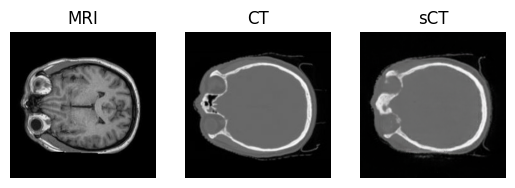

In [ ]:
import matplotlib.pyplot as plt

def show_imgs(i):
    plt.subplot(1, 3, 1)
    img = plt.imread(f'/content/drive/MyDrive/cs280_sp2023/project/pytorch-CycleGAN-and-pix2pix/results/brain_mri2ct/test_latest/images/{i}_real_A.png')
    plt.imshow(img)
    plt.title('MRI')
    plt.axis('off')

    plt.subplot(1, 3, 2)
    img = plt.imread(f'/content/drive/MyDrive/cs280_sp2023/project/pytorch-CycleGAN-and-pix2pix/results/brain_mri2ct/test_latest/images/{i}_real_B.png')
    plt.imshow(img)
    plt.title('CT')
    plt.axis('off')

    plt.subplot(1, 3, 3)
    img = plt.imread(f'/content/drive/MyDrive/cs280_sp2023/project/pytorch-CycleGAN-and-pix2pix/results/brain_mri2ct/test_latest/images/{i}_fake_B.png')
    plt.imshow(img)
    plt.title('sCT')
    plt.axis('off')
    plt.show()

show_imgs(0)

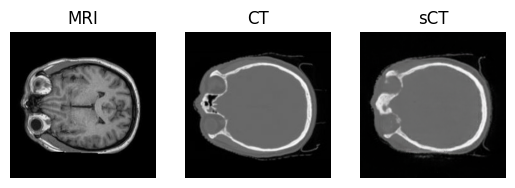

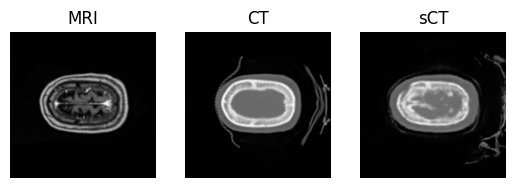

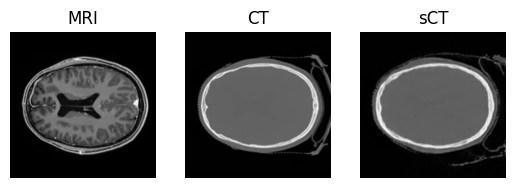

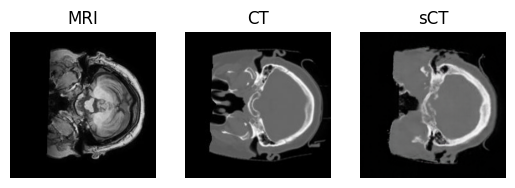

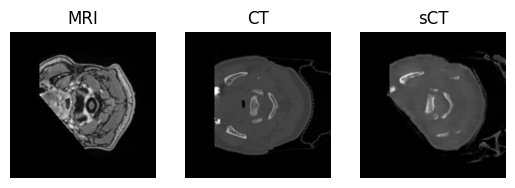

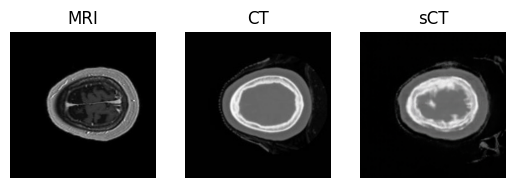

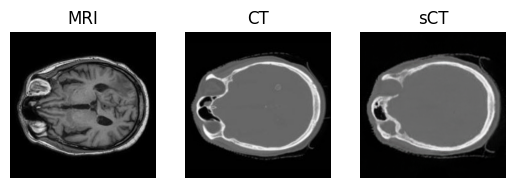

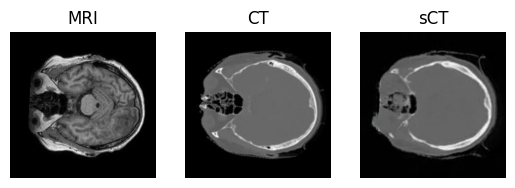

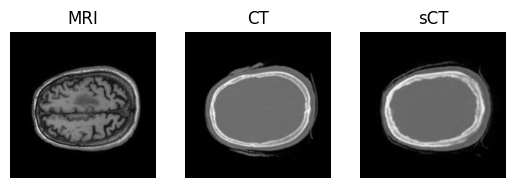

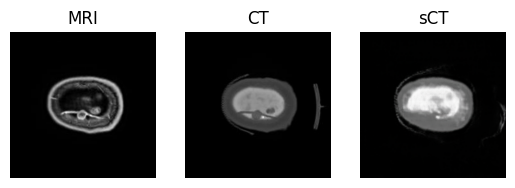

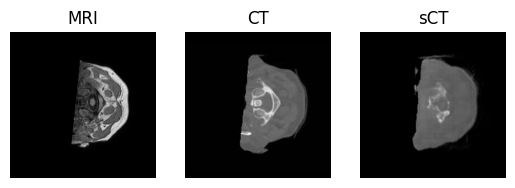

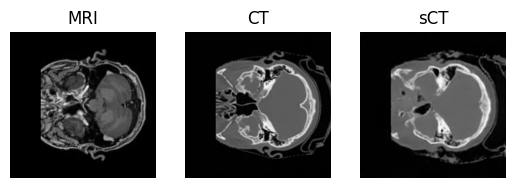

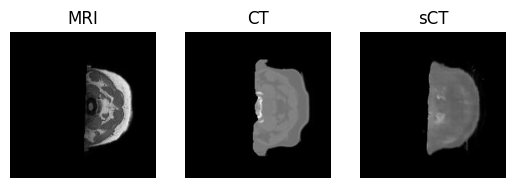

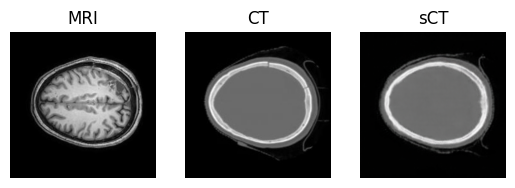

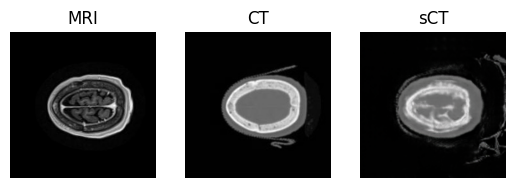

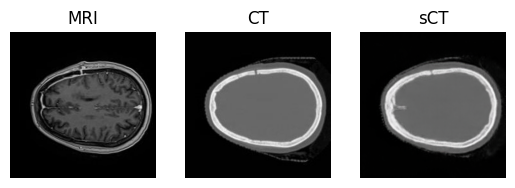

In [ ]:
for i in range(20):
    if os.path.exists(f'/content/drive/MyDrive/cs280_sp2023/project/pytorch-CycleGAN-and-pix2pix/results/brain_mri2ct/test_latest/images/{i}_fake_B.png'):
        show_imgs(i)